# 네이버 영화 리뷰 감성분류 모델 구현(LSTM)
- 데이터 : Naver sentiment movie corpus v1.0,  https://github.com/e9t/nsmc/

### 구글 코랩 한글 깨짐 현상 해결
- 한글폰트 설치
- 런타임 다시 시작

In [ ]:
! sudo apt-get install -y fonts-nanum
! sudo fc-cache -fv
! rm ~/.cache/matplotlib -rf

## 라이브러리 임포트

In [2]:
import os
import re
import random
import urllib.request
import numpy as np 
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from wordcloud import WordCloud

import torch
import torch.nn as nn
import torch.optim as optim
from torchtext import data, datasets
from torchtext.legacy.data import BucketIterator
from torchtext.legacy import data
from torchtext.legacy.data import TabularDataset

%matplotlib inline
plt.rc('font', family='NanumBarunGothic') 

## 구글 드라이브 마운트

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## 데이터 저장 디렉토리 생성

In [4]:
DATA_PATH = '/content/drive/MyDrive/pytorch/nsmc/'

if not os.path.exists(DATA_PATH):
    os.makedirs(DATA_PATH)

## 데이터 가져오기

In [5]:
file = ['ratings.txt', 'ratings_train.txt', 'ratings_test.txt']
for f in file:
    URL = "https://github.com/e9t/nsmc/raw/master/" + f
    FILE_NAME = DATA_PATH + f
    urllib.request.urlretrieve(URL, filename=FILE_NAME)

In [6]:
for file in os.listdir(DATA_PATH):
    if 'txt' in file :
        print(f'{file : <20} {os.path.getsize(DATA_PATH + file) / 1000000: ,.2f} MB')

ratings_test_small.txt  0.19 MB
ratings_test.txt      4.89 MB
ratings_train_small.txt  1.96 MB
ratings_train.txt     14.63 MB
ratings.txt           19.52 MB


## 데이터 로드

In [7]:
train_data = pd.read_csv(DATA_PATH + 'ratings_train.txt', header = 0, delimiter = '\t', quoting = 3)
train_data.head()

,id,document,label
0,9976970,아 더빙.. 진짜 짜증나네요 목소리,0
1,3819312,흠...포스터보고 초딩영화줄....오버연기조차 가볍지 않구나,1
2,10265843,너무재밓었다그래서보는것을추천한다,0
3,9045019,교도소 이야기구먼 ..솔직히 재미는 없다..평점 조정,0
4,6483659,사이몬페그의 익살스런 연기가 돋보였던 영화!스파이더맨에서 늙어보이기만 했던 커스틴 ...,1


## 데이터 분석
- 데이터의 개수
- 리뷰의 문자 길이 분포
- 많이 사용된 단어
- 긍정, 부정 데이터(label)의 분포
- 리뷰의 단어 개수 분포

### 데이터 개수

In [8]:
print(f'Train 데이터 개수: {len(train_data):,}')

Train 데이터 개수: 150,000


In [9]:
train_length = train_data['document'].astype(str).apply(len)

### 리뷰의 문자 길이 분포

Text(0, 0.5, '리뷰 갯수')

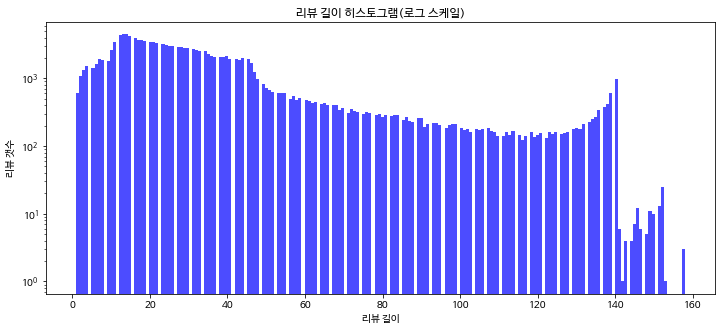

In [10]:
plt.figure(figsize=(12, 5))
plt.hist(train_length, bins=200, alpha=0.7, color= 'b', label='word')
plt.yscale('log', nonposy='clip')
plt.title('리뷰 길이 히스토그램(로그 스케일)')
plt.xlabel('리뷰 길이')
plt.ylabel('리뷰 갯수')

In [11]:
print(f'리뷰 길이 최대 값: {np.max(train_length)}')
print(f'리뷰 길이 최소 값: {np.min(train_length)}')
print(f'리뷰 길이 평균 값: {np.mean(train_length):.2f}')
print(f'리뷰 길이 표준편차: {np.std(train_length):.2f}')
print(f'리뷰 길이 중간값: {np.median(train_length)}')
print(f'리뷰 길이 제 1 사분위: {np.percentile(train_length, 25)}')
print(f'리뷰 길이 제 3 사분위: {np.percentile(train_length, 75)}')

리뷰 길이 최대 값: 158
리뷰 길이 최소 값: 1
리뷰 길이 평균 값: 35.24
리뷰 길이 표준편차: 29.58
리뷰 길이 중간값: 27.0
리뷰 길이 제 1 사분위: 16.0
리뷰 길이 제 3 사분위: 42.0


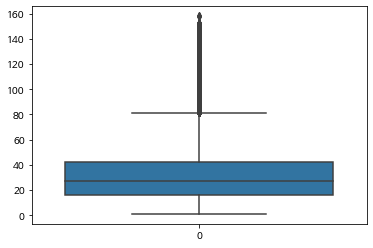

In [12]:
sns.boxplot(orient = "v", data=train_length)

### 많이 사용된 단어 분석 - Word Cloud

(-0.5, 399.5, 199.5, -0.5)

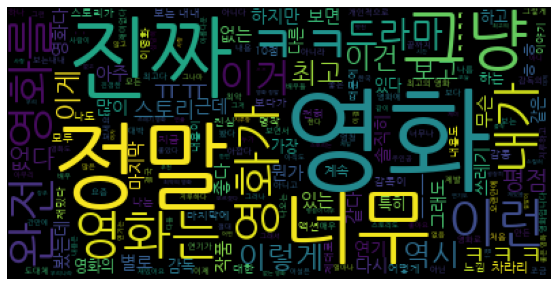

In [13]:
train_review = [review for review in train_data['document'] if type(review) is str]
stopwords = ('그리고', 'ㅋ')
wordcloud = WordCloud(stopwords=stopwords, font_path='NanumGothic.ttf')
wordcloud = wordcloud.generate(' '.join(train_review))

plt.figure(figsize=(10, 5))
plt.imshow(wordcloud)
plt.axis('off')

### 긍정, 부정 데이터의 분포

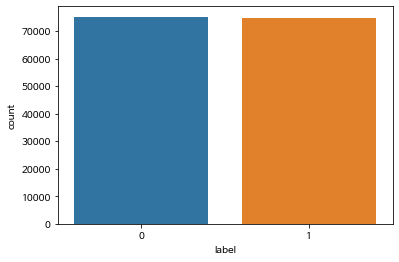

In [14]:
sns.countplot(x='label', data=train_data)

### 리뷰의 단어 개수 분포

Text(0, 0.5, '개수')

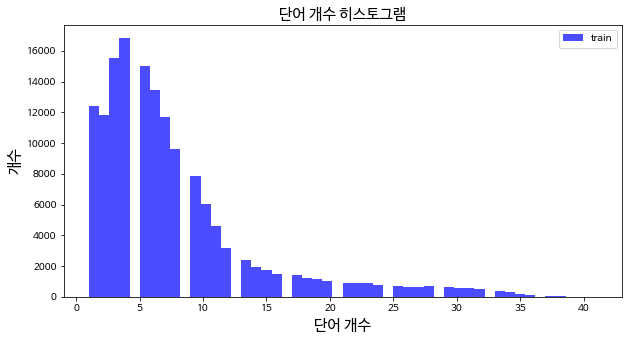

In [15]:
train_word_counts = train_data['document'].astype(str).apply(lambda x:len(x.split(' ')))

plt.figure(figsize=(10, 5))
plt.hist(train_word_counts, bins=50, alpha=0.7, color= 'b', label='train')
plt.title('단어 개수 히스토그램', fontsize=15)
# plt.yscale('log', nonposy='clip')
plt.legend()
plt.xlabel('단어 개수', fontsize=15)
plt.ylabel('개수', fontsize=15)

In [16]:
print(f'리뷰 단어 개수 최대 값: {np.max(train_word_counts)}')
print(f'리뷰 단어 개수 최소 값: {np.min(train_word_counts)}')
print(f'리뷰 단어 개수 평균 값: {np.mean(train_word_counts):.2f}')
print(f'리뷰 단어 개수 표준편차: {np.std(train_word_counts):.2f}')
print(f'리뷰 단어 개수 중간 값: {np.median(train_word_counts)}')
print(f'리뷰 단어 개수 제 1 사분위: {np.percentile(train_word_counts, 25)}')
print(f'리뷰 단어 개수 제 3 사분위: {np.percentile(train_word_counts, 75)}')

리뷰 단어 개수 최대 값: 41
리뷰 단어 개수 최소 값: 1
리뷰 단어 개수 평균 값: 7.58
리뷰 단어 개수 표준편차: 6.51
리뷰 단어 개수 중간 값: 6.0
리뷰 단어 개수 제 1 사분위: 3.0
리뷰 단어 개수 제 3 사분위: 9.0


##  Small 데이터셋 생성(실습 시간 단축 목적)

In [17]:
train_df = pd.read_csv(os.path.join(DATA_PATH, "ratings_train.txt"), sep='\t', encoding='utf-8')
test_df = pd.read_csv(os.path.join(DATA_PATH, "ratings_test.txt"), sep='\t', encoding='utf-8')

train_df[:20000].to_csv(os.path.join(DATA_PATH, "ratings_train_small.txt"), sep='\t', index=False)
test_df[:2000].to_csv(os.path.join(DATA_PATH, "ratings_test_small.txt"), sep='\t', index=False)

In [18]:
print(train_df.shape)
print(test_df.shape)

(150000, 3)
(50000, 3)


## 한국어 전처리 및 토크나이징

In [ ]:
! pip install konlpy

In [20]:
from konlpy.tag import Okt, Komoran, Hannanum, Kkma

tokenizer = Okt()
tokenizer.morphs('안녕하세요. 오늘 날씨가 참 좋습니다!')

['안녕하세요', '.', '오늘', '날씨', '가', '참', '좋습니다', '!']

In [21]:
def preprocess_sent(sentence):
    # sentence = re.sub("[^가-힣0-9a-zA-Z\\s]", " ", x)
    sentence = tokenizer.morphs(sentence)
    return sentence

In [22]:
train_df[:10]

,id,document,label
0,9976970,아 더빙.. 진짜 짜증나네요 목소리,0
1,3819312,흠...포스터보고 초딩영화줄....오버연기조차 가볍지 않구나,1
2,10265843,너무재밓었다그래서보는것을추천한다,0
3,9045019,교도소 이야기구먼 ..솔직히 재미는 없다..평점 조정,0
4,6483659,사이몬페그의 익살스런 연기가 돋보였던 영화!스파이더맨에서 늙어보이기만 했던 커스틴 ...,1
5,5403919,막 걸음마 뗀 3세부터 초등학교 1학년생인 8살용영화.ㅋㅋㅋ...별반개도 아까움.,0
6,7797314,원작의 긴장감을 제대로 살려내지못했다.,0
7,9443947,별 반개도 아깝다 욕나온다 이응경 길용우 연기생활이몇년인지..정말 발로해도 그것보단...,0
8,7156791,액션이 없는데도 재미 있는 몇안되는 영화,1
9,5912145,왜케 평점이 낮은건데? 꽤 볼만한데.. 헐리우드식 화려함에만 너무 길들여져 있나?,1


In [23]:
test_df[:10]

,id,document,label
0,6270596,굳 ㅋ,1
1,9274899,GDNTOPCLASSINTHECLUB,0
2,8544678,뭐야 이 평점들은.... 나쁘진 않지만 10점 짜리는 더더욱 아니잖아,0
3,6825595,지루하지는 않은데 완전 막장임... 돈주고 보기에는....,0
4,6723715,3D만 아니었어도 별 다섯 개 줬을텐데.. 왜 3D로 나와서 제 심기를 불편하게 하죠??,0
5,7898805,"음악이 주가 된, 최고의 음악영화",1
6,6315043,진정한 쓰레기,0
7,6097171,"마치 미국애니에서 튀어나온듯한 창의력없는 로봇디자인부터가,고개를 젖게한다",0
8,8932678,갈수록 개판되가는 중국영화 유치하고 내용없음 폼잡다 끝남 말도안되는 무기에 유치한c...,0
9,6242223,"이별의 아픔뒤에 찾아오는 새로운 인연의 기쁨 But, 모든 사람이 그렇지는 않네..",1


In [24]:
# 필드 정의
TEXT = data.Field(sequential=True,
                  use_vocab=True,
                  tokenize=preprocess_sent,
                  lower=True,
                  batch_first=True,
                  include_lengths=True)

LABEL = data.LabelField(dtype = torch.float)

In [25]:
train_ds, test_ds = TabularDataset.splits(
    path=DATA_PATH,
    train=os.path.join(DATA_PATH, "ratings_train_small.txt"),
    test=os.path.join(DATA_PATH, "ratings_test_small.txt"), format='tsv',
    fields=[(id, None), ('text', TEXT), ('label', LABEL)], skip_header=True)

train_ds, valid_ds = train_ds.split(random_state = random.seed(42))

In [26]:
print(vars(test_ds[9]))

{'text': ['이별', '의', '아픔', '뒤', '에', '찾아오는', '새로운', '인연', '의', '기쁨', 'but', ',', '모든', '사람', '이', '그렇지는', '않네', '..'], 'label': '1'}


In [27]:
print(train_ds.fields.items())

dict_items([(<built-in function id>, None), ('text', <torchtext.legacy.data.field.Field object at 0x7f95400e2850>), ('label', <torchtext.legacy.data.field.LabelField object at 0x7f95400e2810>)])


In [28]:
TEXT.build_vocab(train_ds, min_freq=10, max_size=2000)

LABEL.build_vocab(train_ds)

In [29]:
print(len(TEXT.vocab))

2002


In [30]:
print(TEXT.vocab.stoi)

defaultdict(<bound method Vocab._default_unk_index of <torchtext.vocab.Vocab object at 0x7f95400e5850>>, {'<unk>': 0, '<pad>': 1, '.': 2, '이': 3, '영화': 4, '의': 5, '..': 6, '가': 7, '에': 8, '을': 9, '...': 10, '도': 11, '들': 12, '는': 13, ',': 14, '은': 15, '를': 16, '한': 17, '?': 18, '너무': 19, '다': 20, '정말': 21, '적': 22, '만': 23, '진짜': 24, '!': 25, '으로': 26, '로': 27, '점': 28, '에서': 29, '연기': 30, '과': 31, '것': 32, '평점': 33, '최고': 34, '안': 35, '나': 36, '내': 37, '잘': 38, '그': 39, '~': 40, '와': 41, '인': 42, '왜': 43, '이런': 44, '스토리': 45, '사람': 46, '못': 47, '....': 48, '이다': 49, '감동': 50, '드라마': 51, '하고': 52, '생각': 53, '1': 54, '보고': 55, '고': 56, '하는': 57, '게': 58, '때': 59, '말': 60, '더': 61, '아': 62, '그냥': 63, '감독': 64, 'ㅋㅋ': 65, '요': 66, '본': 67, '거': 68, '재미': 69, '!!': 70, '내용': 71, '까지': 72, '중': 73, '배우': 74, '시간': 75, '보다': 76, '쓰레기': 77, '좀': 78, '없는': 79, '뭐': 80, '지': 81, '네': 82, '수': 83, '작품': 84, '없다': 85, '사랑': 86, '이건': 87, '할': 88, '같은': 89, '정도': 90, '볼': 91, '하나': 92, '10': 93, '봤

In [31]:
BATCH_SIZE = 16
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

train_iterator, valid_iterator, test_iterator = data.BucketIterator.splits(
    (train_ds, valid_ds, test_ds), 
    batch_size = BATCH_SIZE,
    sort_within_batch = True,
    sort_key = lambda x: len(x.text),
    device = device)

## 분류모델 클래스 아키텍처

In [32]:
class Classifier(nn.Module):

    def __init__(self, vocab_size, embedding_dim, hidden_dim, output_dim, n_layers, 
                 bidirectional, dropout, pad_idx):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim, padding_idx = pad_idx)
        self.rnn = nn.LSTM(embedding_dim, 
                           hidden_dim, 
                           num_layers=n_layers, 
                           bidirectional=bidirectional, 
                           dropout=dropout)
        self.fc = nn.Linear(hidden_dim * 2, output_dim)
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, text, text_lengths):
        #text = [sent len, batch size]
        embedded = self.dropout(self.embedding(text))        
        #embedded = [sent len, batch size, emb dim] 
        # pack sequence
        packed_embedded = nn.utils.rnn.pack_padded_sequence(embedded, text_lengths.to('cpu'), batch_first=True)
        packed_output, (hidden, cell) = self.rnn(packed_embedded)
        
        #unpack sequence
        output, output_lengths = nn.utils.rnn.pad_packed_sequence(packed_output)
        #output = [sent len, batch size, hid dim * num directions]
        #output over padding tokens are zero tensors
        #hidden = [num layers * num directions, batch size, hid dim]
        #cell = [num layers * num directions, batch size, hid dim]
        #concat the final forward (hidden[-2,:,:]) and backward (hidden[-1,:,:]) hidden layers
        #and apply dropout
        hidden = self.dropout(torch.cat((hidden[-2,:,:], hidden[-1,:,:]), dim = 1))
        #hidden = [batch size, hid dim * num directions]     
        return self.fc(hidden)

In [33]:
INPUT_DIM = len(TEXT.vocab)
EMBEDDING_DIM = 200
HIDDEN_DIM = 256
OUTPUT_DIM = 1
N_LAYERS = 2
BIDIRECTIONAL = True
DROPOUT = 0.5
PAD_IDX = TEXT.vocab.stoi[TEXT.pad_token]

model = Classifier(INPUT_DIM, 
            EMBEDDING_DIM, 
            HIDDEN_DIM, 
            OUTPUT_DIM, 
            N_LAYERS, 
            BIDIRECTIONAL, 
            DROPOUT, 
            PAD_IDX)

In [34]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f'The model has {count_parameters(model):,} trainable parameters')

The model has 2,915,857 trainable parameters


In [35]:
UNK_IDX = TEXT.vocab.stoi[TEXT.unk_token]

model.embedding.weight.data[UNK_IDX] = torch.zeros(EMBEDDING_DIM)
model.embedding.weight.data[PAD_IDX] = torch.zeros(EMBEDDING_DIM)

print(model.embedding.weight.data)

tensor([[ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [-1.9449, -0.8958,  0.0928,  ...,  1.4600,  0.5450,  0.3749],
        ...,
        [-0.6532,  0.5826, -1.5376,  ...,  0.0203,  0.0393,  0.4673],
        [-2.4184,  1.1874,  1.6921,  ..., -0.2530, -0.2660, -0.4084],
        [ 1.0717, -0.1344, -0.9162,  ..., -1.3813, -1.9346, -1.5713]])


In [36]:
optimizer = optim.Adam(model.parameters())
criterion = nn.BCEWithLogitsLoss()

model = model.to(device)
criterion = criterion.to(device)

In [37]:
def binary_accuracy(preds, y):
    """
    Returns accuracy per batch, i.e. if you get 8/10 right, this returns 0.8, NOT 8
    """

    #round predictions to the closest integer
    rounded_preds = torch.round(torch.sigmoid(preds))
    correct = (rounded_preds == y).float() #convert into float for division 
    acc = correct.sum() / len(correct)
    return acc

In [38]:
def train(model, iterator, optimizer, criterion):
    
    epoch_loss = 0
    epoch_acc = 0
    
    model.train()
    
    for batch in iterator:
        
        optimizer.zero_grad()
        text, text_lengths = batch.text
        predictions = model(text, text_lengths).squeeze(1)
        loss = criterion(predictions, batch.label)
        acc = binary_accuracy(predictions, batch.label)
        
        loss.backward()
        
        optimizer.step()
        
        epoch_loss += loss.item()
        epoch_acc += acc.item()
        
    return epoch_loss / len(iterator), epoch_acc / len(iterator)

In [39]:
def evaluate(model, iterator, criterion):   
    epoch_loss = 0
    epoch_acc = 0  
    model.eval()
    with torch.no_grad():
        for batch in iterator:
            text, text_lengths = batch.text       
            predictions = model(text, text_lengths).squeeze(1)   
            loss = criterion(predictions, batch.label)
            acc = binary_accuracy(predictions, batch.label)
            epoch_loss += loss.item()
            epoch_acc += acc.item()
    return epoch_loss / len(iterator), epoch_acc / len(iterator)

In [40]:
epochs = 10
best_valid_loss = float('inf')

for epoch in range(epochs):
    train_loss, train_acc = train(model, train_iterator, optimizer, criterion)
    valid_loss, valid_acc = evaluate(model, valid_iterator, criterion)
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), os.path.join(DATA_PATH, 'nsmc-lstm.pt'))
    
    print(f'Epoch: {epoch+1:02}')
    print(f'\tTrain     Loss: {train_loss:.3f} | Train      Acc: {train_acc*100:.2f}%')
    print(f'\Validation Loss: {valid_loss:.3f} | Validation Acc: {valid_acc*100:.2f}%')

Epoch: 01
	Train     Loss: 0.597 | Train      Acc: 66.69%
\Validation Loss: 0.504 | Validation Acc: 74.40%
Epoch: 02
	Train     Loss: 0.497 | Train      Acc: 75.15%
\Validation Loss: 0.459 | Validation Acc: 77.72%
Epoch: 03
	Train     Loss: 0.444 | Train      Acc: 79.01%
\Validation Loss: 0.469 | Validation Acc: 78.25%
Epoch: 04
	Train     Loss: 0.409 | Train      Acc: 80.62%
\Validation Loss: 0.433 | Validation Acc: 79.93%
Epoch: 05
	Train     Loss: 0.378 | Train      Acc: 82.64%
\Validation Loss: 0.434 | Validation Acc: 80.05%
Epoch: 06
	Train     Loss: 0.354 | Train      Acc: 83.69%
\Validation Loss: 0.441 | Validation Acc: 80.00%
Epoch: 07
	Train     Loss: 0.331 | Train      Acc: 85.12%
\Validation Loss: 0.468 | Validation Acc: 80.00%
Epoch: 08
	Train     Loss: 0.309 | Train      Acc: 86.06%
\Validation Loss: 0.462 | Validation Acc: 80.13%
Epoch: 09
	Train     Loss: 0.291 | Train      Acc: 87.10%
\Validation Loss: 0.473 | Validation Acc: 80.08%
Epoch: 10
	Train     Loss: 0.277 | Tr

In [41]:
model.load_state_dict(torch.load(os.path.join(DATA_PATH, 'nsmc-lstm.pt')))

test_loss, test_acc = evaluate(model, test_iterator, criterion)

print(f'Test Loss: {test_loss:.3f} | Test Acc: {test_acc*100:.2f}%')

Test Loss: 0.445 | Test Acc: 79.90%


In [42]:
def sentiment_classification(model, sentence):
    model.eval()
    tokenized = preprocess_sent(sentence)
    indexed = [[TEXT.vocab.stoi[t] for t in tokenized]]
    length = [len(indexed)]

    tensor = torch.LongTensor(indexed).to(device)
    length_tensor = torch.LongTensor(length)
    pred = torch.sigmoid(model(tensor, length_tensor))
    
    return pred.item()

In [43]:
sentiment_classification(model, '액션이 멋있었어요.')

0.903477132320404